In [1]:
import numpy as np
import matplotlib.pyplot as plt
import healpy as hp
import sys
import os
from pathlib import Path
import glob
import h5py

In [2]:
# Add project root directory to make imports possible
root_dir = "/mnt/c/Users/tokiw/workspace/LensingSSC"

project_root = Path(root_dir)
sys.path.append(str(project_root))

In [3]:
from lensing_ssc.utils.io import load_results_from_hdf5
from lensing_ssc.core.fibonacci.fibonacci import FibonacciGrid
from lensing_ssc.core.fibonacci.optimizer import PatchOptimizer
from lensing_ssc.core.fibonacci.plotting import plot_coverage_map, plot_fibonacci_grid
from lensing_ssc.core.fibonacci.coverage import CoverageAnalyzer

In [4]:
# Jupyter plotting settings
import seaborn as sns
import matplotlib as mpl

%matplotlib inline
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = [15, 5]

In [5]:
# Parameter settings
nside = 512  # Healpix resolution (in actual analysis, 1024 is used, but set to lower resolution for faster display)
patch_size = 10  # Patch size (degrees)
Ninit = 265  # Upper limit of initial patch count

# Directory to save results
results_dir = project_root / "output" 
savedir = root_dir + "/output/figures"
os.makedirs(results_dir, exist_ok=True)


In [6]:
from astropy.cosmology import FlatLambdaCDM

cosmo = FlatLambdaCDM(H0=67.74, Om0=0.309)
sboxsize = 625
bboxsize = 5000

In [7]:
import glob
import numpy as np

from lensing_ssc.core.patch.statistics.analyzer import PatchAnalyzer
from lensing_ssc.utils.io import save_results_to_hdf5, load_results_from_hdf5

/mnt/c/Users/tokiw/workspace/LensingSSC/.venv/lib/python3.12/site-packages/lenstools/utils/mpi.py:15: UserWarning: Could not import mpi4py! (if you set sys.modules['mpi4py']=None please disregard this message)
  warnings.warn(wmsg)
/mnt/c/Users/tokiw/workspace/LensingSSC/.venv/lib/python3.12/site-packages/lenstools/simulations/cfhtemu1.py:5: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import resource_filename


In [8]:
# Create optimizer
optimizer = PatchOptimizer(nside=nside, patch_size=patch_size, Ninit=Ninit)

N_opt = optimizer.optimize(verbose=True) 

# Generate Fibonacci grid points
points = FibonacciGrid.fibonacci_grid_on_sphere(N_opt)
black_list = [132]

# Scenario 1 mask (True = invalid points)
mask1 = CoverageAnalyzer.build_mask_first_scenario(points, optimizer)
valid_idx_scenario1 = np.where(~mask1)[0]

# Scenario 2 mask (True = invalid points)
mask2 = CoverageAnalyzer.build_mask_second_scenario(points, optimizer)
valid_idx_scenario2 = np.where(~mask2)[0]

# Patches valid in scenario 1 but excluded in scenario 2
excluded_in_scenario2 = np.setdiff1d(valid_idx_scenario1, valid_idx_scenario2)

# Patches valid in both scenario 1 and scenario 2
valid_idx = np.intersect1d(valid_idx_scenario1, valid_idx_scenario2)

if black_list in excluded_in_scenario2:
    #remove the indices of black_list from excluded_in_scenario2
    excluded_in_scenario2 = np.delete(excluded_in_scenario2, np.where(excluded_in_scenario2 == black_list))
    

print(f"Number of valid patches in scenario 1: {len(valid_idx_scenario1)}")
print(f"Number of valid patches in scenario 2: {len(valid_idx_scenario2)}")
print(f"Number of patches valid in scenario 1 but excluded in scenario 2: {len(excluded_in_scenario2)}")
print(f"Indices of excluded patches: {excluded_in_scenario2}")
print(f"Number of patches remaining after applying both scenarios: {len(valid_idx)}")
print(f"Indices of remaining patches: {valid_idx}")

Testing feasibility for N = 133 ...
N = 133 is feasible; trying larger values.
Testing feasibility for N = 201 ...
N = 201 is feasible; trying larger values.
Testing feasibility for N = 235 ...
N = 235 is feasible; trying larger values.
Testing feasibility for N = 251 ...
N = 251 is feasible; trying larger values.
Testing feasibility for N = 259 ...
N = 259 is feasible; trying larger values.
Testing feasibility for N = 263 ...
N = 263 is feasible; trying larger values.
Testing feasibility for N = 265 ...
N = 265 is feasible; trying larger values.
Number of valid patches in scenario 1: 257
Number of valid patches in scenario 2: 186
Number of patches valid in scenario 1 but excluded in scenario 2: 70
Indices of excluded patches: [  5   7   9  22  24  26  41  43  45  58  60  62  77  79  94  96  98 113
 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 133
 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 151 166
 168 170 185 187 202 204 206 219 221 223 238

# RIPs vs. RMPs

In [9]:
zs_list = [0.5, 1.0, 1.5, 2.0, 2.5]
ngal_list = [0, 7, 15, 30, 50]
sl_list = [2, 5, 8, 10]
box_type = ["bigbox", "tiled"]
stats_name = ['power_spectra', 'equilateral', 'isosceles', 'squeezed', 'pdf', 'peaks', 'minima','v0', 'v1', 'v2']
combined_data_RIP = {}
combined_data_RMP = {}

# Initialize data structures for both RIP and RMP
for box in box_type:
    for zs in zs_list:
        combined_data_RIP[(box, zs)] = {}
        combined_data_RMP[(box, zs)] = {}
        for ngal in ngal_list:
            for sl in sl_list:
                combined_data_RIP[(box, zs)][('ngal_'+str(ngal), 'sl_'+str(sl))] = {}
                combined_data_RMP[(box, zs)][('ngal_'+str(ngal), 'sl_'+str(sl))] = {}
                for stats in stats_name:
                    combined_data_RIP[(box, zs)][('ngal_'+str(ngal), 'sl_'+str(sl))][stats] = []
                    combined_data_RMP[(box, zs)][('ngal_'+str(ngal), 'sl_'+str(sl))][stats] = []

# Process data files
for box in box_type:
    for zs in zs_list:
        # Use glob to find all matching files
        file_pattern = f"{root_dir}/output/{box}/stats/stats_zs{zs}_s*_oa10.h5"
        matching_files = glob.glob(file_pattern)
        
        if not matching_files:
            print(f"No files found for {box} box at zs={zs}")
            continue

        # Initialize lists to store data from all files
        file_count = 0
        
        for fname in matching_files:
            try:
                # Load data
                result = load_results_from_hdf5(fname)
                print(f"Loaded summary statistics for {box} box at zs={zs} from {fname}")
                
                # Process power spectra
                if 'power_spectra' in result:
                    for ngal_key, ps_data in result['power_spectra'].items():
                        if 'cl' in ps_data:
                            for sl in sl_list:
                                # Store data for RMP (valid_idx) and RIP (excluded_in_scenario2)
                                combined_data_RMP[(box, zs)][(ngal_key, 'sl_'+str(sl))]['power_spectra'].append(ps_data['cl'][valid_idx])
                                combined_data_RIP[(box, zs)][(ngal_key, 'sl_'+str(sl))]['power_spectra'].append(ps_data['cl'][excluded_in_scenario2])
                
                # Process bispectra
                if 'bispectra' in result:
                    for ngal_key, bs_data in result['bispectra'].items():
                        for bs_type in ['equilateral', 'isosceles', 'squeezed']:
                            if bs_type in bs_data:
                                for sl in sl_list:
                                    # Store data for both RMP and RIP
                                    combined_data_RMP[(box, zs)][(ngal_key, 'sl_'+str(sl))][bs_type].append(bs_data[bs_type][valid_idx])
                                    combined_data_RIP[(box, zs)][(ngal_key, 'sl_'+str(sl))][bs_type].append(bs_data[bs_type][excluded_in_scenario2])
                
                # Process smoothed statistics
                if 'smoothed_statistics' in result:
                    for ngal_key, ngal_data in result['smoothed_statistics'].items():
                        for sl_key, sl_data in ngal_data.items():
                            # PDF, peaks, minima
                            for stat_type in ['pdf', 'peaks', 'minima']:
                                if stat_type in sl_data:
                                    combined_data_RMP[(box, zs)][(ngal_key, sl_key)][stat_type].append(sl_data[stat_type][valid_idx])
                                    combined_data_RIP[(box, zs)][(ngal_key, sl_key)][stat_type].append(sl_data[stat_type][excluded_in_scenario2])
                        
                            # Minkowski functionals
                            if 'minkowski' in sl_data:
                                for mf in ['v0', 'v1', 'v2']:
                                    if mf in sl_data['minkowski']:
                                        combined_data_RMP[(box, zs)][(ngal_key, sl_key)][mf].append(sl_data['minkowski'][mf][valid_idx])
                                        combined_data_RIP[(box, zs)][(ngal_key, sl_key)][mf].append(sl_data['minkowski'][mf][excluded_in_scenario2])
                
                file_count += 1
            
            except Exception as e:
                print(f"Error processing file {fname}: {e}")
        
        print(f"Successfully processed {file_count} files for {box} box at zs={zs}")

Loaded summary statistics for bigbox box at zs=0.5 from /mnt/c/Users/tokiw/workspace/LensingSSC/output/bigbox/stats/stats_zs0.5_s100_oa10.h5
Loaded summary statistics for bigbox box at zs=0.5 from /mnt/c/Users/tokiw/workspace/LensingSSC/output/bigbox/stats/stats_zs0.5_s102_oa10.h5
Loaded summary statistics for bigbox box at zs=0.5 from /mnt/c/Users/tokiw/workspace/LensingSSC/output/bigbox/stats/stats_zs0.5_s104_oa10.h5
Loaded summary statistics for bigbox box at zs=0.5 from /mnt/c/Users/tokiw/workspace/LensingSSC/output/bigbox/stats/stats_zs0.5_s106_oa10.h5
Loaded summary statistics for bigbox box at zs=0.5 from /mnt/c/Users/tokiw/workspace/LensingSSC/output/bigbox/stats/stats_zs0.5_s108_oa10.h5
Loaded summary statistics for bigbox box at zs=0.5 from /mnt/c/Users/tokiw/workspace/LensingSSC/output/bigbox/stats/stats_zs0.5_s110_oa10.h5
Loaded summary statistics for bigbox box at zs=0.5 from /mnt/c/Users/tokiw/workspace/LensingSSC/output/bigbox/stats/stats_zs0.5_s112_oa10.h5
Loaded summar

In [10]:
# Initialize dictionaries for storing results for both RMP and RIP
means_RMP = {}
stds_RMP = {}
correlations_RMP = {}
covariances_RMP = {}
all_stats_RMP = {}

means_RIP = {}
stds_RIP = {}
correlations_RIP = {}
covariances_RIP = {}
all_stats_RIP = {}

# Process RMP data
for box_type in ['bigbox', 'tiled']:
    for zs in zs_list:
        if (box_type, zs) not in combined_data_RMP:
            print(f"No RMP data for {box_type} box at z={zs}")
            continue

        for (ngal, sl), stats_dict in combined_data_RMP[(box_type, zs)].items():
            # Add to the list for correlation analysis
            if (box_type, zs) not in all_stats_RMP: all_stats_RMP[(box_type, zs)] = {}
            if (ngal, sl) not in all_stats_RMP[(box_type, zs)]: all_stats_RMP[(box_type, zs)][(ngal, sl)] = {}
            
            for stat_type, stat_arrays in stats_dict.items():
                if len(stat_arrays) == 0:
                    continue
                    
                # Stack arrays if multiple simulations available
                if isinstance(stat_arrays[0], np.ndarray):
                    stacked = np.vstack(stat_arrays)  # Shape: (n_sims, n_patches, n_bins)
                    
                    # Calculate mean and std across simulations for each patch and bin
                    mean_stats = np.mean(stacked, axis=0)  # Shape: (n_patches, n_bins)
                    std_stats = np.std(stacked, axis=0)    # Shape: (n_patches, n_bins)
                    
                    # Initialize dictionaries if needed
                    if (box_type, zs) not in means_RMP: means_RMP[(box_type, zs)] = {}
                    if (box_type, zs) not in stds_RMP: stds_RMP[(box_type, zs)] = {}
                    if (ngal, sl) not in means_RMP[(box_type, zs)]: means_RMP[(box_type, zs)][(ngal, sl)] = {}
                    if (ngal, sl) not in stds_RMP[(box_type, zs)]: stds_RMP[(box_type, zs)][(ngal, sl)] = {}
                    
                    # Store mean and std statistics
                    means_RMP[(box_type, zs)][(ngal, sl)][stat_type] = mean_stats
                    stds_RMP[(box_type, zs)][(ngal, sl)][stat_type] = std_stats
                    all_stats_RMP[(box_type, zs)][(ngal, sl)][stat_type] = stacked
                    
                    # Calculate correlation and covariance matrices
                    covariance_matrix = np.cov(stacked, rowvar=False)
                    correlation_matrix = np.corrcoef(stacked, rowvar=False)
                    
                    # Initialize dictionaries if needed
                    if (box_type, zs) not in covariances_RMP: covariances_RMP[(box_type, zs)] = {}
                    if (box_type, zs) not in correlations_RMP: correlations_RMP[(box_type, zs)] = {}
                    if (ngal, sl) not in covariances_RMP[(box_type, zs)]: covariances_RMP[(box_type, zs)][(ngal, sl)] = {}
                    if (ngal, sl) not in correlations_RMP[(box_type, zs)]: correlations_RMP[(box_type, zs)][(ngal, sl)] = {}
                    
                    # Store covariance and correlation matrices
                    covariances_RMP[(box_type, zs)][(ngal, sl)][stat_type] = covariance_matrix
                    correlations_RMP[(box_type, zs)][(ngal, sl)][stat_type] = correlation_matrix
            
# Process RIP data
for box_type in ['bigbox', 'tiled']:
    for zs in zs_list:
        if (box_type, zs) not in combined_data_RIP:
            print(f"No RIP data for {box_type} box at z={zs}")
            continue

        for (ngal, sl), stats_dict in combined_data_RIP[(box_type, zs)].items():
            # Add to the list for correlation analysis
            if (box_type, zs) not in all_stats_RIP: all_stats_RIP[(box_type, zs)] = {}
            if (ngal, sl) not in all_stats_RIP[(box_type, zs)]: all_stats_RIP[(box_type, zs)][(ngal, sl)] = {}
            
            for stat_type, stat_arrays in stats_dict.items():
                if len(stat_arrays) == 0:
                    continue
                    
                # Stack arrays if multiple simulations available
                if isinstance(stat_arrays[0], np.ndarray):
                    stacked = np.vstack(stat_arrays)  # Shape: (n_sims, n_patches, n_bins)
                    
                    # Calculate mean and std across simulations for each patch and bin
                    mean_stats = np.mean(stacked, axis=0)  # Shape: (n_patches, n_bins)
                    std_stats = np.std(stacked, axis=0)    # Shape: (n_patches, n_bins)
                    
                    # Initialize dictionaries if needed
                    if (box_type, zs) not in means_RIP: means_RIP[(box_type, zs)] = {}
                    if (box_type, zs) not in stds_RIP: stds_RIP[(box_type, zs)] = {}
                    if (ngal, sl) not in means_RIP[(box_type, zs)]: means_RIP[(box_type, zs)][(ngal, sl)] = {}
                    if (ngal, sl) not in stds_RIP[(box_type, zs)]: stds_RIP[(box_type, zs)][(ngal, sl)] = {}
                    
                    # Store mean and std statistics
                    means_RIP[(box_type, zs)][(ngal, sl)][stat_type] = mean_stats
                    stds_RIP[(box_type, zs)][(ngal, sl)][stat_type] = std_stats
                    all_stats_RIP[(box_type, zs)][(ngal, sl)][stat_type] = stacked
                    
                    # Calculate correlation and covariance matrices
                    covariance_matrix = np.cov(stacked, rowvar=False)
                    correlation_matrix = np.corrcoef(stacked, rowvar=False)
                    
                    # Initialize dictionaries if needed
                    if (box_type, zs) not in covariances_RIP: covariances_RIP[(box_type, zs)] = {}
                    if (box_type, zs) not in correlations_RIP: correlations_RIP[(box_type, zs)] = {}
                    if (ngal, sl) not in covariances_RIP[(box_type, zs)]: covariances_RIP[(box_type, zs)][(ngal, sl)] = {}
                    if (ngal, sl) not in correlations_RIP[(box_type, zs)]: correlations_RIP[(box_type, zs)][(ngal, sl)] = {}
                    
                    # Store covariance and correlation matrices
                    covariances_RIP[(box_type, zs)][(ngal, sl)][stat_type] = covariance_matrix
                    correlations_RIP[(box_type, zs)][(ngal, sl)][stat_type] = correlation_matrix

print(f"Processed RMP statistics for {len(means_RMP)} box/redshift combinations")
print(f"Processed RIP statistics for {len(means_RIP)} box/redshift combinations")

/mnt/c/Users/tokiw/workspace/LensingSSC/.venv/lib/python3.12/site-packages/numpy/lib/_function_base_impl.py:3065: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/mnt/c/Users/tokiw/workspace/LensingSSC/.venv/lib/python3.12/site-packages/numpy/lib/_function_base_impl.py:3066: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Processed RMP statistics for 10 box/redshift combinations
Processed RIP statistics for 10 box/redshift combinations


In [11]:
from matplotlib.gridspec import GridSpec, GridSpecFromSubplotSpec
from matplotlib.lines import Line2D

bins = result['metadata']['parameters']['bins']
l_edges = result['metadata']['parameters']['l_edges']
ell = result['metadata']['parameters']['ell']
nu = result['metadata']['parameters']['nu']

colors = ["tab:blue", "tab:orange", "tab:green", "tab:red", "tab:purple"]
survey_info = {
    '0': 'Noiseless',
    '7': 'DES',
    '15': 'HSC',
    '30': 'LSST',
    '50': 'Roman'
}

labels_ell = ["power_spectra", "equilateral", "isosceles", "squeezed"]
titles_ell = ["$C_{\ell}$", "$B_{\ell}^{(eq)}$", "$B_{\ell}^{(iso)}$", "$B_{\ell}^{(sq)}$"]
fontsize = 16

labels_nu = ["pdf", "peaks", "minima", "v0", "v1", "v2"]
titles_nu = ["PDF", "Peaks", "Minima", "$V_0$", "$V_1$", "$V_2$"]

lmin, lmax = 300, 3000
mranges_ell = [(0.99, 1.005), (0.9, 1.1), (0.9, 1.1), (0.9, 1.1)]
vranges_ell = [(0.95, 1.25), (0.9, 1.2), (0.9, 1.2), (0.9, 1.2)]
savedir = root_dir + "/output/figures"

mranges_nu = [(0.99, 1.015), (0.99, 1.015),(0.97, 1.05),(0.97, 1.03), (0.97, 1.03), (0.97, 1.03)]
vranges_nu = [(0.95, 1.3),(0.95, 1.3), (0.95, 1.3), (0.95, 1.3), (0.95, 1.3), (0.95, 1.3)]

ngal = 'ngal_0'  # Using noiseless case
sl = 'sl_2'      # Using smoothing length 2

<>:19: SyntaxWarning: invalid escape sequence '\e'
<>:19: SyntaxWarning: invalid escape sequence '\e'
<>:19: SyntaxWarning: invalid escape sequence '\e'
<>:19: SyntaxWarning: invalid escape sequence '\e'
<>:19: SyntaxWarning: invalid escape sequence '\e'
<>:19: SyntaxWarning: invalid escape sequence '\e'
<>:19: SyntaxWarning: invalid escape sequence '\e'
<>:19: SyntaxWarning: invalid escape sequence '\e'
/tmp/ipykernel_2290/2946330513.py:19: SyntaxWarning: invalid escape sequence '\e'
  titles_ell = ["$C_{\ell}$", "$B_{\ell}^{(eq)}$", "$B_{\ell}^{(iso)}$", "$B_{\ell}^{(sq)}$"]
/tmp/ipykernel_2290/2946330513.py:19: SyntaxWarning: invalid escape sequence '\e'
  titles_ell = ["$C_{\ell}$", "$B_{\ell}^{(eq)}$", "$B_{\ell}^{(iso)}$", "$B_{\ell}^{(sq)}$"]
/tmp/ipykernel_2290/2946330513.py:19: SyntaxWarning: invalid escape sequence '\e'
  titles_ell = ["$C_{\ell}$", "$B_{\ell}^{(eq)}$", "$B_{\ell}^{(iso)}$", "$B_{\ell}^{(sq)}$"]
/tmp/ipykernel_2290/2946330513.py:19: SyntaxWarning: invalid esc

/tmp/ipykernel_2290/2191917323.py:44: RuntimeWarning: invalid value encountered in divide
  ax_nu_mean[j].plot(nu, bigbox_mean/tiled_mean, color=colors[i])
/tmp/ipykernel_2290/2191917323.py:47: RuntimeWarning: invalid value encountered in divide
  ax_nu_var[j].plot(nu, bigbox_var/tiled_var, color=colors[i])
/tmp/ipykernel_2290/2191917323.py:44: RuntimeWarning: divide by zero encountered in divide
  ax_nu_mean[j].plot(nu, bigbox_mean/tiled_mean, color=colors[i])
/tmp/ipykernel_2290/2191917323.py:47: RuntimeWarning: divide by zero encountered in divide
  ax_nu_var[j].plot(nu, bigbox_var/tiled_var, color=colors[i])
/tmp/ipykernel_2290/2191917323.py:99: RuntimeWarning: invalid value encountered in divide
  ax_nu_mean[j].plot(nu, bigbox_mean/tiled_mean, color=colors[i], linestyle="--")
/tmp/ipykernel_2290/2191917323.py:102: RuntimeWarning: invalid value encountered in divide
  ax_nu_var[j].plot(nu, bigbox_var/tiled_var, color=colors[i], linestyle="--")


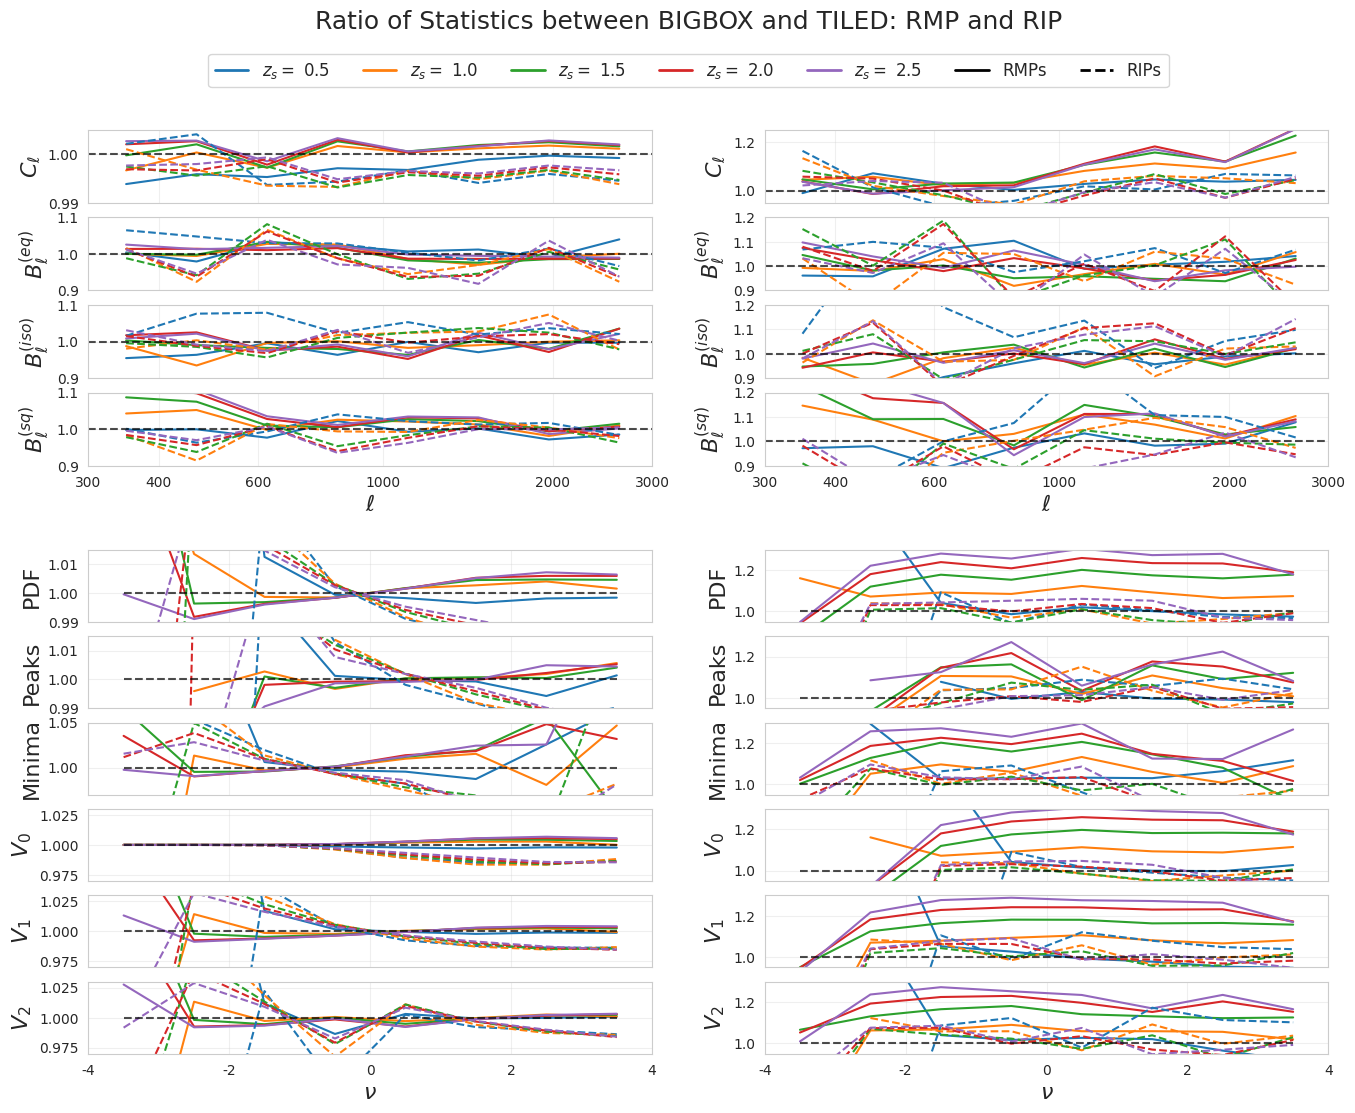

In [12]:
# RMPとRIPの両方の比率を一つの図にまとめる
from matplotlib import lines


fig = plt.figure(figsize=(16, 12))

fig.suptitle(r"Ratio of Statistics between BIGBOX and TILED: RMP and RIP", fontsize=18, y=0.98)

# グリッドレイアウトを設定
gs_master = GridSpec(2, 2, height_ratios=[len(labels_ell), len(labels_nu)], width_ratios=[1, 1], wspace=0.2, hspace=0.2)
gs_ell_mean = GridSpecFromSubplotSpec(len(labels_ell), 1, subplot_spec=gs_master[0,0], hspace=0.2)
gs_ell_var = GridSpecFromSubplotSpec(len(labels_ell), 1, subplot_spec=gs_master[0,1], hspace=0.2)
gs_nu_mean = GridSpecFromSubplotSpec(len(labels_nu), 1, subplot_spec=gs_master[1,0], hspace=0.2)
gs_nu_var = GridSpecFromSubplotSpec(len(labels_nu), 1, subplot_spec=gs_master[1,1], hspace=0.2)

ax_ell_mean = [fig.add_subplot(gs_ell_mean[i, 0]) for i in range(len(labels_ell))]
ax_ell_var = [fig.add_subplot(gs_ell_var[i, 0]) for i in range(len(labels_ell))]
ax_nu_mean = [fig.add_subplot(gs_nu_mean[i, 0]) for i in range(len(labels_nu))]
ax_nu_var = [fig.add_subplot(gs_nu_var[i, 0]) for i in range(len(labels_nu))]

# === RMP部分 ===
# nu-binned RMP ratios
for i, zs_i in enumerate(zs_list):
    for j, label in enumerate(labels_nu):
        # データが両方のシミュレーションタイプに存在するかチェック
        if (('bigbox', zs_i) in means_RMP and (ngal, sl) in means_RMP[('bigbox', zs_i)] and
            ('tiled', zs_i) in means_RMP and (ngal, sl) in means_RMP[('tiled', zs_i)]):
            
            # 現在の統計量のデータを取得
            if label in means_RMP[('bigbox', zs_i)][(ngal, sl)] and label in means_RMP[('tiled', zs_i)][(ngal, sl)]:
                # 両シミュレーションタイプから平均を取得
                bigbox_mean = means_RMP[('bigbox', zs_i)][(ngal, sl)][label]
                tiled_mean = means_RMP[('tiled', zs_i)][(ngal, sl)][label]
                
                # 標準偏差を取得
                bigbox_std = stds_RMP[('bigbox', zs_i)][(ngal, sl)][label]
                tiled_std = stds_RMP[('tiled', zs_i)][(ngal, sl)][label]
                
                # 共分散行列の対角要素（分散）を取得
                bigbox_var = bigbox_std**2
                tiled_var = tiled_std**2
                
                # 平均の比率をプロット
                ax_nu_mean[j].plot(nu, bigbox_mean/tiled_mean, color=colors[i])
                
                # 分散の比率をプロット
                ax_nu_var[j].plot(nu, bigbox_var/tiled_var, color=colors[i])

# ell-binned RMP ratios
for i, zs_i in enumerate(zs_list):
    for j, label in enumerate(labels_ell):
        # データが両方のシミュレーションタイプに存在するかチェック
        if (('bigbox', zs_i) in means_RMP and (ngal, sl) in means_RMP[('bigbox', zs_i)] and
            ('tiled', zs_i) in means_RMP and (ngal, sl) in means_RMP[('tiled', zs_i)]):
            
            # 現在の統計量のデータを取得
            if label in means_RMP[('bigbox', zs_i)][(ngal, sl)] and label in means_RMP[('tiled', zs_i)][(ngal, sl)]:
                # 両シミュレーションタイプから平均を取得
                bigbox_mean = means_RMP[('bigbox', zs_i)][(ngal, sl)][label]
                tiled_mean = means_RMP[('tiled', zs_i)][(ngal, sl)][label]
                
                # 標準偏差を取得
                bigbox_std = stds_RMP[('bigbox', zs_i)][(ngal, sl)][label]
                tiled_std = stds_RMP[('tiled', zs_i)][(ngal, sl)][label]
                
                # 共分散行列の対角要素（分散）を取得
                bigbox_var = bigbox_std**2
                tiled_var = tiled_std**2
                
                # 平均の比率をプロット
                ax_ell_mean[j].plot(ell, bigbox_mean/tiled_mean, color=colors[i])
                
                # 分散の比率をプロット
                ax_ell_var[j].plot(ell, bigbox_var/tiled_var, color=colors[i])

# === RIP部分 ===
# nu-binned RIP ratios
for i, zs_i in enumerate(zs_list):
    for j, label in enumerate(labels_nu):
        # データが両方のシミュレーションタイプに存在するかチェック
        if (('bigbox', zs_i) in means_RIP and (ngal, sl) in means_RIP[('bigbox', zs_i)] and
            ('tiled', zs_i) in means_RIP and (ngal, sl) in means_RIP[('tiled', zs_i)]):
            
            # 現在の統計量のデータを取得
            if label in means_RIP[('bigbox', zs_i)][(ngal, sl)] and label in means_RIP[('tiled', zs_i)][(ngal, sl)]:
                # 両シミュレーションタイプから平均を取得
                bigbox_mean = means_RIP[('bigbox', zs_i)][(ngal, sl)][label]
                tiled_mean = means_RIP[('tiled', zs_i)][(ngal, sl)][label]
                
                # 標準偏差を取得
                bigbox_std = stds_RIP[('bigbox', zs_i)][(ngal, sl)][label]
                tiled_std = stds_RIP[('tiled', zs_i)][(ngal, sl)][label]
                
                # 共分散行列の対角要素（分散）を取得
                bigbox_var = bigbox_std**2
                tiled_var = tiled_std**2
                
                # 平均の比率をプロット
                ax_nu_mean[j].plot(nu, bigbox_mean/tiled_mean, color=colors[i], linestyle="--")
                
                # 分散の比率をプロット
                ax_nu_var[j].plot(nu, bigbox_var/tiled_var, color=colors[i], linestyle="--")

# ell-binned RIP ratios
for i, zs_i in enumerate(zs_list):
    for j, label in enumerate(labels_ell):
        # データが両方のシミュレーションタイプに存在するかチェック
        if (('bigbox', zs_i) in means_RIP and (ngal, sl) in means_RIP[('bigbox', zs_i)] and
            ('tiled', zs_i) in means_RIP and (ngal, sl) in means_RIP[('tiled', zs_i)]):
            
            # 現在の統計量のデータを取得
            if label in means_RIP[('bigbox', zs_i)][(ngal, sl)] and label in means_RIP[('tiled', zs_i)][(ngal, sl)]:
                # 両シミュレーションタイプから平均を取得
                bigbox_mean = means_RIP[('bigbox', zs_i)][(ngal, sl)][label]
                tiled_mean = means_RIP[('tiled', zs_i)][(ngal, sl)][label]
                
                # 標準偏差を取得
                bigbox_std = stds_RIP[('bigbox', zs_i)][(ngal, sl)][label]
                tiled_std = stds_RIP[('tiled', zs_i)][(ngal, sl)][label]
                
                # 共分散行列の対角要素（分散）を取得
                bigbox_var = bigbox_std**2
                tiled_var = tiled_std**2
                
                # 平均の比率をプロット
                ax_ell_mean[j].plot(ell, bigbox_mean/tiled_mean, color=colors[i], linestyle="--")
                
                # 分散の比率をプロット
                ax_ell_var[j].plot(ell, bigbox_var/tiled_var, color=colors[i], linestyle="--")

# nuパネルの設定
for i, ax in enumerate(ax_nu_mean + ax_nu_var):
    ax.set_xscale("linear")
    ax.set_xlim(nu.min(), nu.max())
    ax.set_xticks([-4, -2, 0, 2, 4])
    ax.hlines(1, nu.min(), nu.max(), color="black", linestyle="--", alpha=0.7)
    ax.grid(True, alpha=0.3)
    if i == len(ax_nu_mean)-1 or i == len(ax_nu_mean) + len(ax_nu_var)-1:
        ax.set_xticklabels(["-4", "-2", "0", "2", "4"])
        ax.set_xlabel(r"$\nu$", fontsize=fontsize)
    else:
        ax.tick_params(labelbottom=False, labeltop=False, labelright=False)

# ellパネルの設定
for i, ax in enumerate(ax_ell_mean + ax_ell_var):
    ax.set_xscale("log")
    ax.set_xlim(lmin, lmax)
    ax.set_xticks([300, 400, 600, 1000, 2000, 3000])
    ax.hlines(1, lmin, lmax, color="black", linestyle="--", alpha=0.7)
    ax.grid(True, alpha=0.3)
    if i == len(ax_ell_mean)-1 or i == len(ax_ell_mean) + len(ax_ell_var)-1:
        ax.set_xticklabels(["300", "400", "600", "1000", "2000", "3000"])
        ax.set_xlabel(r"$\ell$", fontsize=fontsize)
    else:
        ax.tick_params(labelbottom=False, labeltop=False, labelright=False)
    


# Y軸の範囲を設定（必要に応じて調整）
for i, ax in enumerate(ax_nu_mean):
    ax.set_ylim(mranges_nu[i])
    ax.set_ylabel(titles_nu[i], fontsize=fontsize)
for i, ax in enumerate(ax_nu_var):
    ax.set_ylim(vranges_nu[i])
    ax.set_ylabel(titles_nu[i], fontsize=fontsize)
for i, ax in enumerate(ax_ell_mean):
    ax.set_ylim(mranges_ell[i])
    ax.set_ylabel(titles_ell[i], fontsize=fontsize)
for i, ax in enumerate(ax_ell_var):
    ax.set_ylim(vranges_ell[i])
    ax.set_ylabel(titles_ell[i], fontsize=fontsize)

custom_lines = [Line2D([0], [0], color=colors[i], lw=2) for i in range(len(zs_list))]
custom_lines2 = [Line2D([0], [0], linestyle=ls, lw=2, color="black") for ls in ["-", "--"]]

fig.legend(custom_lines + custom_lines2, [f"$z_s =$ {zs}" for zs in zs_list] + ["RMPs", "RIPs"], bbox_to_anchor=(0.5, 0.95), loc='upper center', ncol=len(zs_list) + 2, fontsize=12)

# 図を保存
fig.savefig(os.path.join(savedir, "combined_ratios_RMP_RIP.pdf"), bbox_inches="tight")

# Bad Patch

In [13]:
zs_list = [0.5, 1.0, 1.5, 2.0, 2.5]
ngal_list = [0, 7, 15, 30, 50]
sl_list = [2, 5, 8, 10]
box_type = ["bigbox", "tiled"]
stats_name = ['power_spectra', 'equilateral', 'isosceles', 'squeezed', 'pdf', 'peaks', 'minima','v0', 'v1', 'v2']
combined_bl = {}

for box in box_type:
    for zs in zs_list:
        combined_bl[(box, zs)] = {}
        for ngal in ngal_list:
            for sl in sl_list:
                combined_bl[(box, zs)][('ngal_'+str(ngal), 'sl_'+str(sl))] = {}
                for stats in stats_name:
                    combined_bl[(box, zs)][('ngal_'+str(ngal), 'sl_'+str(sl))][stats] = []

# Process data files
for box in box_type:
    for zs in zs_list:
        # Use glob to find all matching files
        file_pattern = f"{root_dir}/output/{box}/stats/stats_zs{zs}_s*_oa10.h5"
        matching_files = glob.glob(file_pattern)
        
        if not matching_files:
            print(f"No files found for {box} box at zs={zs}")
            continue

        # Initialize lists to store data from all files
        file_count = 0
        
        for fname in matching_files:
            # Load data
            result = load_results_from_hdf5(fname)
            print(f"Loaded summary statistics for {box} box at zs={zs} from {fname}")
            
            # Process power spectra
            if 'power_spectra' in result:
                for ngal_key, ps_data in result['power_spectra'].items():
                    if 'cl' in ps_data:
                        for sl in sl_list:
                            # Store data for RMP (valid_idx) and RIP (excluded_in_scenario2)
                            combined_bl[(box, zs)][(ngal_key, 'sl_'+str(sl))]['power_spectra'].append(ps_data['cl'][black_list])

Loaded summary statistics for bigbox box at zs=0.5 from /mnt/c/Users/tokiw/workspace/LensingSSC/output/bigbox/stats/stats_zs0.5_s100_oa10.h5
Loaded summary statistics for bigbox box at zs=0.5 from /mnt/c/Users/tokiw/workspace/LensingSSC/output/bigbox/stats/stats_zs0.5_s102_oa10.h5
Loaded summary statistics for bigbox box at zs=0.5 from /mnt/c/Users/tokiw/workspace/LensingSSC/output/bigbox/stats/stats_zs0.5_s104_oa10.h5
Loaded summary statistics for bigbox box at zs=0.5 from /mnt/c/Users/tokiw/workspace/LensingSSC/output/bigbox/stats/stats_zs0.5_s106_oa10.h5
Loaded summary statistics for bigbox box at zs=0.5 from /mnt/c/Users/tokiw/workspace/LensingSSC/output/bigbox/stats/stats_zs0.5_s108_oa10.h5
Loaded summary statistics for bigbox box at zs=0.5 from /mnt/c/Users/tokiw/workspace/LensingSSC/output/bigbox/stats/stats_zs0.5_s110_oa10.h5
Loaded summary statistics for bigbox box at zs=0.5 from /mnt/c/Users/tokiw/workspace/LensingSSC/output/bigbox/stats/stats_zs0.5_s112_oa10.h5
Loaded summar

In [15]:
zs_list = [0.5, 1.0, 1.5, 2.0, 2.5]
ngal_list = [0, 7, 15, 30, 50]
sl_list = [2, 5, 8, 10]
box_type = ["bigbox", "tiled"]
stats_name = ['power_spectra', 'equilateral', 'isosceles', 'squeezed', 'pdf', 'peaks', 'minima','v0', 'v1', 'v2']
combined_data = {}

for box in box_type:
    for zs in zs_list:
        combined_data[(box, zs)] = {}
        for ngal in ngal_list:
            for sl in sl_list:
                combined_data[(box, zs)][('ngal_'+str(ngal), 'sl_'+str(sl))] = {}
                for stats in stats_name:
                    combined_data[(box, zs)][('ngal_'+str(ngal), 'sl_'+str(sl))][stats] = []

for box in box_type:
    for zs in zs_list:
        # Use glob to find all matching files
        file_pattern = f"{root_dir}/output/{box}/stats/stats_zs{zs}_s*_oa10.h5"
        matching_files = glob.glob(file_pattern)
        
        if not matching_files:
            print(f"No files found for {box} box at zs={zs}")
            continue

        # Initialize lists to store data from all files
        file_count = 0
        
        for fname in matching_files:
            try:
                # Load data
                result = load_results_from_hdf5(fname)
                print(f"Loaded summary statistics for {box} box at zs={zs} from {fname}")

                # Extract relevant statistics
                data = {}
                
                # Check if we have the expected structure
                if 'power_spectra' in result:
                    for ngal_key, ps_data in result['power_spectra'].items():
                        if 'cl' in ps_data:
                            for sl in sl_list:
                                combined_data[(box, zs)][(ngal_key, 'sl_'+str(sl))]['power_spectra'].append(ps_data['cl'][valid_idx])
                
                # Process bispectra if available
                if 'bispectra' in result:
                    for ngal_key, bs_data in result['bispectra'].items():
                        for bs_type in ['equilateral', 'isosceles', 'squeezed']:
                            if bs_type in bs_data:
                                for sl in sl_list:
                                    combined_data[(box, zs)][(ngal_key, 'sl_'+str(sl))][bs_type].append(bs_data[bs_type][valid_idx])
                
                # Process smoothed statistics if available
                if 'smoothed_statistics' in result:
                    for ngal_key, ngal_data in result['smoothed_statistics'].items():
                        for sl_key, sl_data in ngal_data.items():
                            # PDF, peaks, minima
                            for stat_type in ['pdf', 'peaks', 'minima']:
                                if stat_type in sl_data:
                                    combined_data[(box, zs)][(ngal_key, sl_key)][stat_type].append(sl_data[stat_type][valid_idx])
                        
                            # Minkowski functionals
                            if 'minkowski' in sl_data:
                                for mf in ['v0', 'v1', 'v2']:
                                    if mf in sl_data['minkowski']:
                                        combined_data[(box, zs)][(ngal_key, sl_key)][mf].append(sl_data['minkowski'][mf][valid_idx])
                
                file_count += 1
            
            except Exception as e:
                print(f"Error processing file {fname}: {e}")
        
        print(f"Successfully processed {file_count} files for {box} box at zs={zs}")

Loaded summary statistics for bigbox box at zs=0.5 from /mnt/c/Users/tokiw/workspace/LensingSSC/output/bigbox/stats/stats_zs0.5_s100_oa10.h5
Loaded summary statistics for bigbox box at zs=0.5 from /mnt/c/Users/tokiw/workspace/LensingSSC/output/bigbox/stats/stats_zs0.5_s102_oa10.h5
Loaded summary statistics for bigbox box at zs=0.5 from /mnt/c/Users/tokiw/workspace/LensingSSC/output/bigbox/stats/stats_zs0.5_s104_oa10.h5
Loaded summary statistics for bigbox box at zs=0.5 from /mnt/c/Users/tokiw/workspace/LensingSSC/output/bigbox/stats/stats_zs0.5_s106_oa10.h5
Loaded summary statistics for bigbox box at zs=0.5 from /mnt/c/Users/tokiw/workspace/LensingSSC/output/bigbox/stats/stats_zs0.5_s108_oa10.h5
Loaded summary statistics for bigbox box at zs=0.5 from /mnt/c/Users/tokiw/workspace/LensingSSC/output/bigbox/stats/stats_zs0.5_s110_oa10.h5
Loaded summary statistics for bigbox box at zs=0.5 from /mnt/c/Users/tokiw/workspace/LensingSSC/output/bigbox/stats/stats_zs0.5_s112_oa10.h5
Loaded summar

In [16]:
# Initialize dictionaries for storing results
means = {}
stds = {}
correlations = {}
covariances = {}
all_stats = {}

# Process data for each simulation box and redshift
for box_type in ['bigbox', 'tiled']:
    for zs in zs_list:
        if (box_type, zs) not in combined_data:
            print(f"No data for {box_type} box at z={zs}")
            continue

        for (ngal, sl), stats_dict in combined_data[(box_type, zs)].items():
            # Add to the list for correlation analysis
            if (box_type, zs) not in all_stats:all_stats[(box_type, zs)] = {}
            if (ngal, sl) not in all_stats[(box_type, zs)]:all_stats[(box_type, zs)][(ngal, sl)] = {}
            for stat_type, stat_arrays in stats_dict.items():
                if len(stat_arrays) == 0:
                    continue
                    
                # Stack arrays if multiple simulations available
                if isinstance(stat_arrays[0], np.ndarray):
                    stacked = np.vstack(stat_arrays)  # Shape: (n_sims, n_patches, n_bins)
                    
                    # Calculate mean and std across simulations for each patch and bin
                    mean_stats = np.mean(stacked, axis=0)  # Shape: (n_patches, n_bins)
                    std_stats = np.std(stacked, axis=0)    # Shape: (n_patches, n_bins)
                    
                    # Flatten to shape (n_patches*n_bins,) for correlation analysis
                    flattened_stats = mean_stats.flatten()
                    
                    if (box_type, zs) not in means:means[(box_type, zs)] = {}
                    if (box_type, zs) not in stds:stds[(box_type, zs)] = {}
                    if (ngal, sl) not in means[(box_type, zs)]:means[(box_type, zs)][(ngal, sl)] = {}
                    if (ngal, sl) not in stds[(box_type, zs)]:stds[(box_type, zs)][(ngal, sl)] = {}
                    
                    means[(box_type, zs)][(ngal, sl)][stat_type] = mean_stats
                    stds[(box_type, zs)][(ngal, sl)][stat_type] = std_stats

                    all_stats[(box_type, zs)][(ngal, sl)][stat_type] = stacked
                    
                    # Calculate correlation and covariance matrices
                    covariance_matrix = np.cov(stacked, rowvar=False)
                    correlation_matrix = np.corrcoef(stacked, rowvar=False)

                    if (box_type, zs) not in covariances:covariances[(box_type, zs)] = {}
                    if (box_type, zs) not in correlations:correlations[(box_type, zs)] = {}
                    if (ngal, sl) not in covariances[(box_type, zs)]:covariances[(box_type, zs)][(ngal, sl)] = {}
                    if (ngal, sl) not in correlations[(box_type, zs)]:correlations[(box_type, zs)][(ngal, sl)] = {}


                    covariances[(box_type, zs)][(ngal, sl)][stat_type] = covariance_matrix
                    correlations[(box_type, zs)][(ngal, sl)][stat_type] = correlation_matrix
            
print(f"Processed statistics for {len(means)} box/redshift combinations")

/mnt/c/Users/tokiw/workspace/LensingSSC/.venv/lib/python3.12/site-packages/numpy/lib/_function_base_impl.py:3065: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/mnt/c/Users/tokiw/workspace/LensingSSC/.venv/lib/python3.12/site-packages/numpy/lib/_function_base_impl.py:3066: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Processed statistics for 10 box/redshift combinations


In [17]:
# Initialize dictionaries for storing results
means = {}
stds = {}

# Process data for each simulation box and redshift
for box_type in ['bigbox', 'tiled']:
    for zs in zs_list:
        if (box_type, zs) not in combined_bl:
            print(f"No data for {box_type} box at z={zs}")
            continue

        for (ngal, sl), stats_dict in combined_bl[(box_type, zs)].items():
            # Add to the list for correlation analysis
            if (box_type, zs) not in all_stats:all_stats[(box_type, zs)] = {}
            if (ngal, sl) not in all_stats[(box_type, zs)]:all_stats[(box_type, zs)][(ngal, sl)] = {}
            for stat_type, stat_arrays in stats_dict.items():
                if len(stat_arrays) == 0:
                    continue
                    
                # Stack arrays if multiple simulations available
                if isinstance(stat_arrays[0], np.ndarray):
                    stacked = np.vstack(stat_arrays)  # Shape: (n_sims, n_patches, n_bins)
                    
                    # Calculate mean and std across simulations for each patch and bin
                    mean_stats = np.mean(stacked, axis=0)  # Shape: (n_patches, n_bins)
                    std_stats = np.std(stacked, axis=0)    # Shape: (n_patches, n_bins)
                    
                    # Flatten to shape (n_patches*n_bins,) for correlation analysis
                    flattened_stats = mean_stats.flatten()
                    
                    if (box_type, zs) not in means:means[(box_type, zs)] = {}
                    if (box_type, zs) not in stds:stds[(box_type, zs)] = {}
                    if (ngal, sl) not in means[(box_type, zs)]:means[(box_type, zs)][(ngal, sl)] = {}
                    if (ngal, sl) not in stds[(box_type, zs)]:stds[(box_type, zs)][(ngal, sl)] = {}
                    
                    means[(box_type, zs)][(ngal, sl)][stat_type] = mean_stats
                    stds[(box_type, zs)][(ngal, sl)][stat_type] = std_stats

<>:4: SyntaxWarning: invalid escape sequence '\e'
<>:41: SyntaxWarning: invalid escape sequence '\p'
<>:4: SyntaxWarning: invalid escape sequence '\e'
<>:41: SyntaxWarning: invalid escape sequence '\p'
/tmp/ipykernel_2172/2022160255.py:4: SyntaxWarning: invalid escape sequence '\e'
  fig.suptitle("Angular Power Spectra $C_\ell$ for Patches with/without $(\pi/2, 0)$ Direction", fontsize=18, y=1.07)
/tmp/ipykernel_2172/2022160255.py:41: SyntaxWarning: invalid escape sequence '\p'
  Line2D([0], [0], color='tab:red', marker='o', label='Patches include $(\pi/2, 0)$ direction')


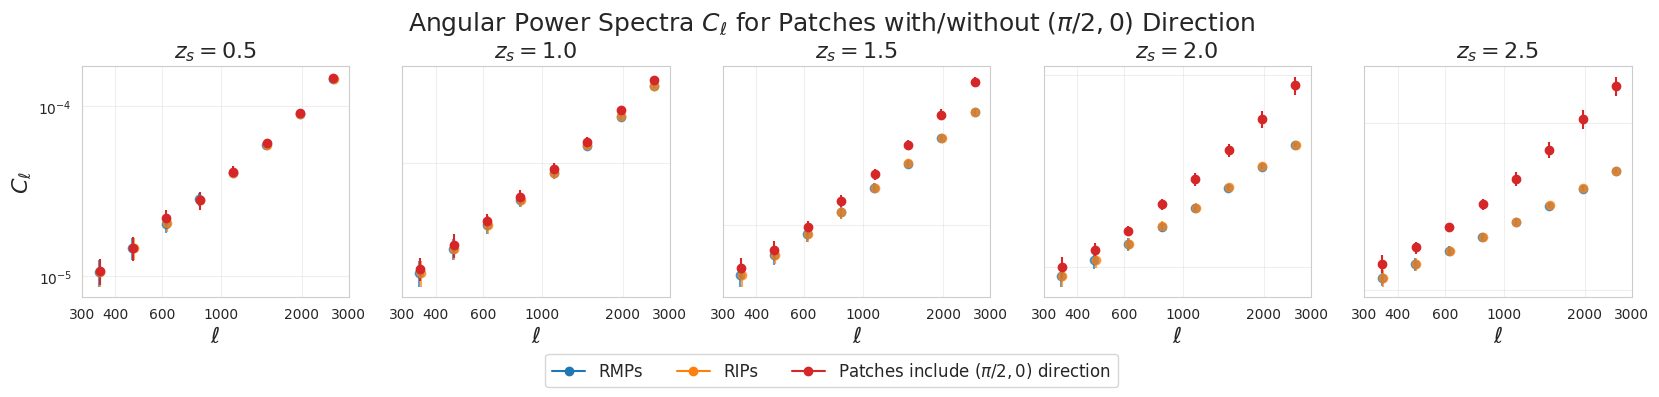

In [ ]:
fig = plt.figure(figsize=(20, 3))
label = "power_spectra"

fig.suptitle("Angular Power Spectra $C_\ell$ for Patches with/without $(\pi/2, 0)$ Direction", fontsize=18, y=1.07)

# グリッドレイアウトを設定
gs_master = GridSpec(1, len(zs_list), wspace=0.2, hspace=0.2)
axs = [fig.add_subplot(gs_master[0, i]) for i in range(len(zs_list))]


for i, zs_i in enumerate(zs_list):
    # 両シミュレーションタイプから平均を取得
    tiled_RMP = means_RMP[('tiled', zs_i)][(ngal, sl)][label]
    tiled_RIP = means_RIP[('tiled', zs_i)][(ngal, sl)][label]
    tiled_bl = means[('tiled', zs_i)][(ngal, sl)][label]
    
    # 平均の比率をプロット
    axs[i].errorbar(ell - np.log10(200), tiled_RMP, yerr=stds_RMP[('tiled', zs_i)][(ngal, sl)][label], color="tab:blue", fmt='o', alpha=0.7)
    axs[i].errorbar(ell + np.log10(200), tiled_RIP, yerr=stds_RIP[('tiled', zs_i)][(ngal, sl)][label], color="tab:orange", fmt='o', alpha=0.7)
    axs[i].errorbar(ell, tiled_bl, yerr=stds[('tiled', zs_i)][(ngal, sl)][label], color="tab:red", fmt='o')

    axs[i].set_xscale("log")
    axs[i].set_yscale("log")
    axs[i].set_xlim(lmin, lmax)
    #axs[i].set_ylim(10**(-5), 0.005)
    axs[i].set_xticks([300, 400, 600, 1000, 2000, 3000])
    axs[i].set_xticklabels(["300", "400", "600", "1000", "2000", "3000"])
    axs[i].set_xlabel(r"$\ell$", fontsize=fontsize)
    axs[i].grid(True, alpha=0.3)
    axs[i].set_title(f"$z_s = {zs_i}$", fontsize=fontsize)
    if i != 0:
        axs[i].set_yticklabels([])

    if i == 0:
        axs[i].set_ylabel(r"$C_\ell$", fontsize=fontsize)
    
# Create legend for the two types of patches
legend_elements = [
    Line2D([0], [0], color='tab:blue', marker='o', label='RMPs'),
    Line2D([0], [0], color='tab:orange', marker='o', label='RIPs'),
    Line2D([0], [0], color='tab:red', marker='o', label='Patches include $(\pi/2, 0)$ direction')
]

fig.legend(handles=legend_elements, loc='upper center', 
           bbox_to_anchor=(0.5, -0.05), ncol=3, fontsize=12)

# 図を保存
fig.savefig(os.path.join(savedir, "badpatch_comparison.pdf"), bbox_inches="tight")